In [1]:
# Standard Library
import datetime
import os
from pathlib import Path

# Third Party Library
import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.stats import rankdata
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

# First Party Library
from src.visualization.plot import (
    image_concat_and_imshow,
    scatter_each_classes,
)

In [10]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markers = ['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']

model_name = "SimpleCAE32"
trained_datetime = "2023-07-10/13-09-32"

project_dir = Path("/home/shinsei/MyResearchs/feat_extrc")

model_save_pardir = project_dir / "models" / "VBGMM"
feature_pardir = project_dir / "reports" / "features" / model_name / trained_datetime
figure_pardir = project_dir / "reports" / "figures" / "VBGMM" / trained_datetime
image_pardir = project_dir / "data/processed/CNTForest/cnt_sem_32x32/10k/"

# feature_csv_path = "/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-07/12-15-24/features.csv"
feature_train_csv_path = feature_pardir / "features_train_data.csv"
feature_check_csv_path = feature_pardir / "features_check_data.csv"

In [11]:
df_train = pl.read_csv(feature_train_csv_path)
X_train = df_train.select([
    pl.exclude(["filename", "dirname"])
]).to_numpy()
df_train.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.085531,0.652696,-0.304715,0.39652,-0.457528,-0.008066,0.455123,-0.260189,0.52101,-0.448034,0.420716,-0.357052,0.443164,0.67313,0.267822,0.324104,-0.2054,-0.477954,0.297364,0.053135,-0.370639,0.318801,-0.135448,-0.37164,-0.590236,0.50582,0.191822,0.859568,0.400706,-0.010296,0.55795,-0.245697,0.002591,-0.777151,0.018459,0.415641,-0.687229,…,0.472361,-0.154558,-0.005131,0.188563,0.079576,-0.361696,0.371474,-0.1703,-0.170322,0.037523,-0.755311,-0.255215,0.329084,-0.559039,0.148205,0.483929,0.462133,0.317056,-0.238316,0.278114,0.230168,-0.440027,0.23421,0.049672,0.186074,-0.156675,0.505174,0.087118,0.442726,1.243564,0.528567,-0.143065,0.580106,-0.298893,0.24718,0,"""10k_0_h000_w00…"
0.304032,-0.701261,-0.26386,-0.245357,-0.389596,0.761918,-0.568226,-0.235638,0.311917,-0.763101,0.783741,-0.75217,0.434609,0.101222,0.354738,0.759906,0.41262,1.118328,0.823532,-0.487695,0.468323,0.658648,0.227937,0.015848,0.186808,-0.782696,-0.028991,-0.333355,0.048682,-0.506766,-0.038069,-0.733807,-0.874561,0.34183,0.053467,0.069988,0.084812,…,0.355786,0.412587,0.41351,-0.298789,-0.319973,-0.211501,0.276795,0.22649,0.088694,-0.0274,0.063887,0.194498,-0.043691,0.245859,0.007315,-0.060991,-0.254315,-0.64672,0.418736,0.188339,-0.118252,-0.520708,-0.382059,-0.787909,0.194903,-0.442135,0.37631,-0.02227,0.08842,0.17507,0.402272,0.35253,0.218535,0.314572,0.778653,0,"""10k_0_h000_w00…"
-0.226996,0.206092,0.267804,-0.407874,0.59533,-0.003093,0.543326,0.310888,1.057553,-0.099924,-0.395329,0.199309,0.184412,0.150461,-0.124427,0.148694,-0.166455,0.525886,0.094284,0.533875,0.637336,0.467281,1.505668,-0.173979,-0.841741,-0.228452,-0.457033,0.420776,0.089381,-0.200824,0.896434,0.800856,-0.56494,0.089009,0.191202,0.045583,0.805474,…,0.6102,-0.004696,0.992365,-0.725928,0.454414,0.591591,-0.061863,0.313815,-0.816505,-0.077432,-0.477634,-0.493816,0.203505,0.197507,-0.238047,0.759813,-0.374865,-0.792639,0.164271,-0.012631,0.299948,0.119889,0.203693,-0.61076,0.038902,0.042869,0.350471,-0.213892,0.430622,-0.910724,0.375349,-0.599376,0.465569,0.14813,0.228808,0,"""10k_0_h000_w00…"
-0.091176,-0.047058,0.350275,0.096058,0.929412,0.439195,-0.430148,0.29032,-0.194786,-0.231615,0.915085,0.184923,0.097621,0.034589,-0.513159,-0.605927,-0.01308,0.437457,-1.102378,0.090877,0.63695,-0.493245,-0.610627,0.10154,-0.079199,0.004654,0.848289,0.156647,-0.171634,-0.293844,0.539354,0.136637,0.183676,0.217675,-0.919009,-0.233645,-0.39545,…,-1.085472,-0.293937,0.480533,-0.066618,0.079391,0.561128,-0.341484,-0.138819,-0.885809,0.607815,-0.541686,-0.476046,0.240496,-0.929571,0.001208,0.491959,-0.557757,0.578768,0.176877,0.500953,0.255943,0.028367,0.097295,0.479268,0.409907,-0.402908,0.397699,0.185982,0.493886,-0.182111,-0.469971,0.350064,0.068668,0.289092,0.364898,0,"""10k_0_h000_w00…"
-0.478116,0.632162,0.032764,0.107446,0.176951,-0.262379,-0.195815,0.255405,0.505611,0.050948,0.413968,0.077098,0.688337,0.484114,-0.754212,-0.294408,-0.710932,0.533701,-0.146862

In [12]:
df_check = pl.read_csv(feature_check_csv_path)
X_check = df_check.select([
    pl.exclude(["filename", "dirname"])
]).to_numpy()
df_check.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.081187,0.641306,-0.29807,0.392791,-0.463166,-0.01242,0.454063,-0.266112,0.517888,-0.4535,0.41035,-0.357184,0.435353,0.665033,0.253357,0.323617,-0.210334,-0.466924,0.293595,0.048125,-0.369211,0.311697,-0.15129,-0.361674,-0.582406,0.513421,0.17603,0.861688,0.389199,-0.031552,0.546803,-0.246826,-0.01077,-0.774627,0.009406,0.416058,-0.686513,…,0.460027,-0.165335,0.000734,0.184057,0.065019,-0.36605,0.356607,-0.180316,-0.165681,0.02002,-0.757273,-0.2726,0.316256,-0.562363,0.159933,0.470357,0.451203,0.316254,-0.242803,0.277422,0.208594,-0.428476,0.23064,0.045281,0.182319,-0.168563,0.496287,0.086871,0.423506,1.223074,0.520453,-0.160121,0.579021,-0.293285,0.232095,0,"""10k_0_h000_w00…"
-0.240604,0.186281,0.280357,-0.407733,0.591664,-0.003713,0.541309,0.310418,1.050839,-0.113707,-0.409277,0.196771,0.183466,0.143439,-0.147569,0.150694,-0.164402,0.524919,0.099723,0.526067,0.638474,0.457185,1.4941,-0.167325,-0.837436,-0.217173,-0.466745,0.427481,0.072993,-0.217203,0.892269,0.79581,-0.573997,0.089553,0.184387,0.052235,0.801418,…,0.593655,-0.017438,0.996491,-0.728317,0.444236,0.585103,-0.090143,0.308813,-0.81049,-0.10033,-0.476777,-0.503833,0.195189,0.188452,-0.218358,0.750219,-0.38594,-0.783674,0.158368,-0.00145,0.284141,0.128518,0.19822,-0.610342,0.039718,0.030443,0.344347,-0.215181,0.409776,-0.919662,0.368075,-0.610561,0.465858,0.147057,0.215668,0,"""10k_0_h000_w00…"
-0.488357,0.622537,0.039477,0.107401,0.167747,-0.263835,-0.197042,0.246984,0.506997,0.04473,0.403341,0.074363,0.682993,0.478376,-0.764804,-0.288972,-0.710901,0.537684,-0.145632,0.006442,-0.077593,-0.055091,-0.441037,-0.004357,-0.424964,0.081613,0.50264,0.004408,-0.125338,-0.081806,-0.225509,-0.194922,-0.025063,0.114091,0.552873,0.360022,-0.211636,…,0.192154,0.763826,-0.089129,-0.718762,-0.278203,0.749432,-0.653637,-0.009453,0.236249,0.23363,-0.785358,0.006613,-0.47849,-0.070813,-0.258218,-0.749164,-0.191288,0.127218,1.022747,0.555098,0.516802,0.501803,-0.678717,0.214815,-0.028941,-0.447416,0.281469,-0.853215,0.129239,0.519929,-0.250867,-0.508604,0.331913,-0.052148,0.051363,0,"""10k_0_h000_w00…"
0.14232,0.833983,0.044417,0.02871,0.28038,0.384736,0.728963,0.417456,0.308815,0.444215,0.388266,-0.531925,0.456765,0.138868,1.056183,-0.425641,0.320917,0.196895,0.071539,0.404908,-0.74635,0.284718,0.343171,-0.938629,-0.971037,0.591346,-0.779473,0.899692,-0.359922,-0.163241,0.803512,0.069276,-0.746752,0.746933,0.383587,-0.558369,-0.072739,…,0.909676,0.331257,-0.0441,0.302166,0.239553,0.354353,0.18268,0.08521,-0.761343,-0.446473,0.304414,-0.952067,-0.047888,-0.554721,0.214581,0.011604,0.392295,0.166104,0.490512,-0.071409,1.012665,0.971091,0.136275,0.075375,-0.548449,0.272786,0.264022,0.351493,-0.281979,0.358343,0.698304,-0.844583,0.143866,-0.191383,-0.360749,0,"""10k_0_h000_w00…"
0.297355,0.001727,0.311982,-0.658734,0.514037,0.085714,0.02021,-0.435643,-0.04251,-0.374594,0.147983,-0.112143,-0.442718,0.002179,-0.409567,0.397173,0.304804,0.197853,-0.5968

In [13]:
sc = StandardScaler()
pca = PCA()

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)

X_check_std = sc.transform(X_check)
X_check_pca = pca.transform(X_check_std)

30


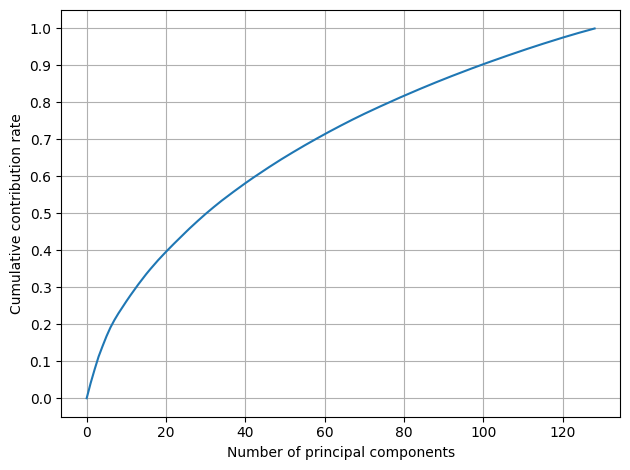

In [14]:
cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()
num_use_features = cumsum_contrb_rate[cumsum_contrb_rate < 0.5].shape[0]
print(num_use_features)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(X_train.shape[1]+1), [0]+list(cumsum_contrb_rate))
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative contribution rate')
ax.set_yticks(np.arange(0., 1.1, 0.1))
ax.grid()
fig.tight_layout()
plt.show()

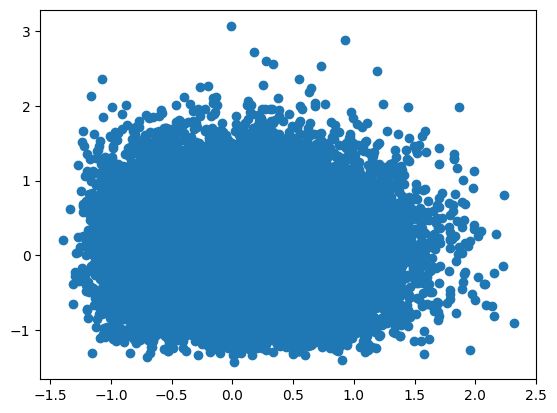

In [15]:
component_01 = df_train.select([pl.col("column_0"), pl.col("column_1")]).to_numpy()
plt.scatter(component_01[:, 0], component_01[:, 1])

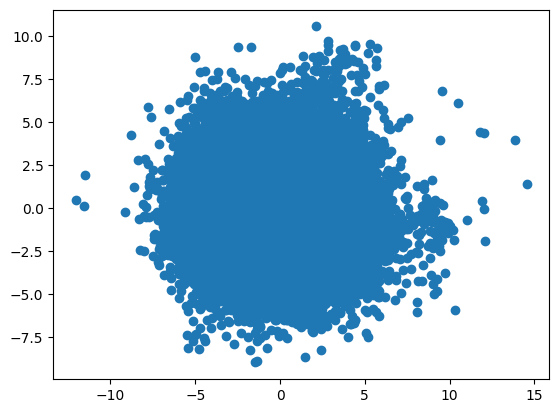

In [16]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])

In [15]:
model_save_dir = model_save_pardir / trained_datetime
model_save_dir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/models/VBGMM/2023-01-31/12-54-00')

vbgmm_pca_40_10clusters
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
Initialization converged: True
Initialization 2
 

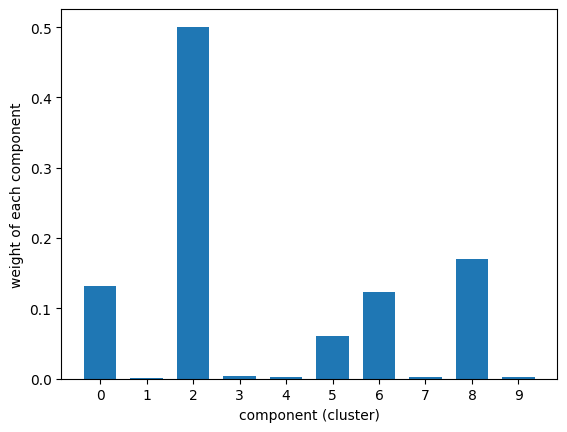

In [16]:
dt = datetime.datetime.now()
nc = 10
max_iter = 500

clustering_type = f'vbgmm_pca_{num_use_features}_{nc}clusters'
print(clustering_type)

vbgmm_train_pca = BayesianGaussianMixture(
    n_components=nc,
    max_iter=500,
    n_init=10,
    init_params="k-means++",
    verbose=1
)
y_train_pca = vbgmm_train_pca.fit_predict(X_train_pca[:,:num_use_features])

# vbgmm_train_pca: BayesianGaussianMixture = joblib.load("/workdir/notebooks/vbgmm_train_pca.pkl")
# y_train_pca = vbgmm_train_pca.predict(X_train_pca[:,:num_use_features])

model_save_dir = model_save_pardir / trained_datetime

if not model_save_dir.exists():
    os.makedirs(model_save_dir)
joblib.dump(vbgmm_train_pca, model_save_dir / f"{clustering_type}_iter{max_iter}.pkl")

rank_of_cluster_train_pca = rankdata(np.histogram(y_train_pca, bins=nc, range=(0, nc))[0], method='ordinal')
y_train_pca_sorted_cluster = rank_of_cluster_train_pca[y_train_pca]


# plt.subplot(4, 1, 4)
x_tick = np.arange(0, nc)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, vbgmm_train_pca.weights_, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

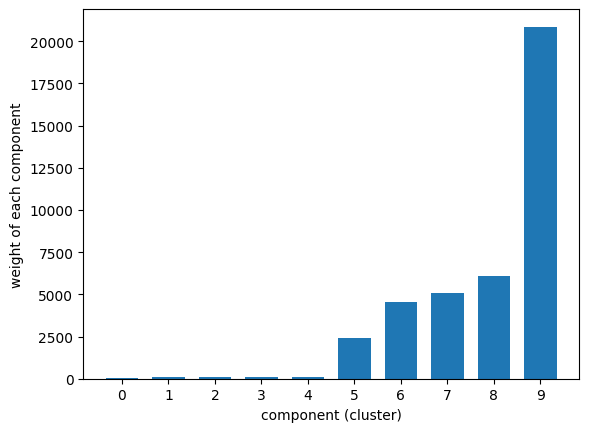

In [18]:
hist, bin_edges = np.histogram(y_train_pca_sorted_cluster)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, hist, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

In [19]:
feature_pardir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE64/2023-01-31/12-54-00')

In [20]:
make_file_path_col = pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/").alias("filepath")
df_train_clustering = df_train.with_columns(
    [make_file_path_col, pl.Series("cluster", y_train_pca_sorted_cluster-1)]
)
df_train_clustering.write_csv(feature_pardir / f"feature_train_data_clustering_VBGMM_iter{max_iter}.csv")

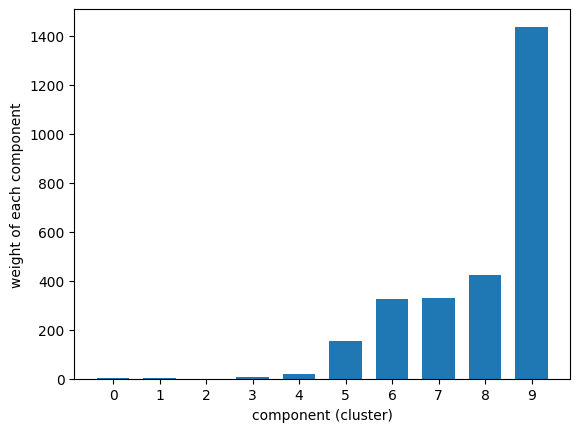

In [21]:
y_check_pca = vbgmm_train_pca.predict(X_check_pca[:, :num_use_features])
y_check_pca_sorted_cluster = rank_of_cluster_train_pca[y_check_pca]

hist, bin_edges = np.histogram(y_check_pca_sorted_cluster)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, hist, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

In [22]:
make_file_path_col = pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/").alias("filepath")
df_check_clustering = df_check.with_columns(
    [make_file_path_col, pl.Series("cluster", y_check_pca_sorted_cluster-1)]
)
df_check_clustering.write_csv(feature_pardir / f"feature_check_data_clustering_VBGMM_iter{max_iter}.csv")

In [23]:
figure_pardir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/reports/figures/VBGMM/2023-01-31/12-54-00')

['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']
max_abs_range=9.744593094178965


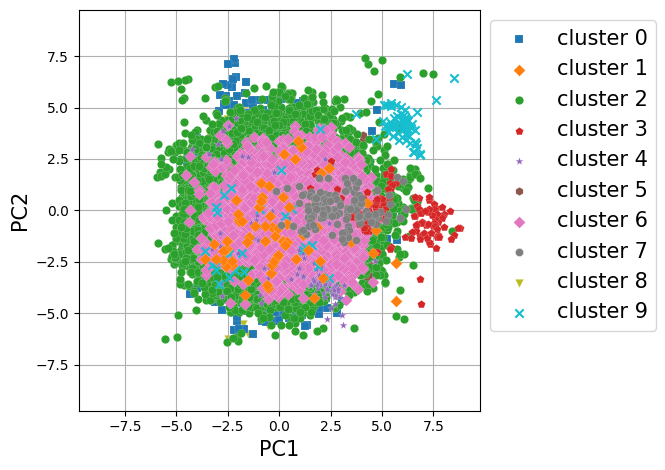

In [31]:
# df_train_clustering = pl.read_csv("/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-10/13-09-32/feature_train_data_clustering.csv")
# # scatter_data = df_train_clustering.select([pl.exclude(["dirname", "filename", "filepath", "cluster"])]).to_numpy()
# cluster_labels = df_train_clustering.select(pl.col("cluster")).to_numpy().flatten()
if not (figure_pardir / f"cluster_images_iter{max_iter}").exists():
    os.makedirs(figure_pardir / f"cluster_images_iter{max_iter}")

scatter_each_classes(
    X_train_pca, 
    # cluster_labels, 
    # y_train_pca_sorted_cluster-1,
    y_train_pca,
    rank_of_cluster_train_pca[::-1],
    markers,
    colors,
    xylabel=("PC1", "PC2"),
    face_color="None",
    fontsize=15,
    # path="../reports/figures/VBGMM/2023-07-14/cluster_images/scatter.png"
    # path = figure_pardir / f"cluster_images_iter{max_iter}" / f"scatter_iter{max_iter}.png"
)

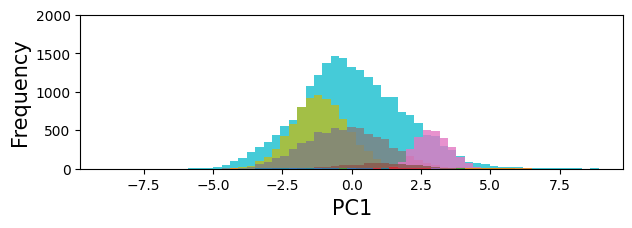

In [59]:
x_min = -9.786490229491115
x_max = 9.786490229491115
fontsize = 15

df_pc1 = pl.DataFrame(X_train_pca[:,0]).with_columns(
    df_train_clustering.select([pl.col("cluster")])
)

min_max = df_pc1.select(
    pl.col("column_0")
).describe().filter(
    (pl.col("describe") == "max" ) | 
    (pl.col("describe") == "min" ) 
).select(
    pl.col("column_0")
).to_numpy().flatten()

fig = plt.figure(figsize=(7,2))
ax = fig.add_subplot(1,1,1)

for i in range(10):
    pc1 = df_pc1.filter(
        pl.col("cluster") == i
    ).select("column_0").to_numpy().flatten()
    
    ax.hist(pc1, bins=50, range=min_max, alpha=0.8, label=f"cluster_{i}", zorder=10-i)
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 2000)

ax.set_xlabel("PC1", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)
fig.savefig(
    fname=figure_pardir / f"cluster_images_iter{max_iter}" / "frequency_pc1.png",
    dpi=fig.get_dpi(),
    bbox_inches="tight"
)

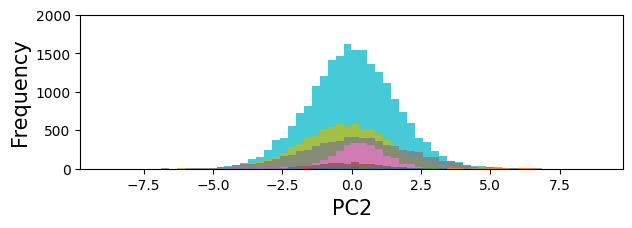

In [60]:
df_pc2 = pl.DataFrame(X_train_pca[:,1]).with_columns(
    df_train_clustering.select([pl.col("cluster")])
)

min_max = df_pc2.select(
    pl.col("column_0")
).describe().filter(
    (pl.col("describe") == "max" ) | 
    (pl.col("describe") == "min" ) 
).select(
    pl.col("column_0")
).to_numpy().flatten()

fig = plt.figure(figsize=(7,2))
ax = fig.add_subplot(1,1,1)

for i in range(10):
    pc1 = df_pc2.filter(
        pl.col("cluster") == i
    ).select("column_0").to_numpy().flatten()
    
    ax.hist(pc1, bins=50, range=min_max, alpha=0.8, label=f"cluster_{i}", zorder=10-i)
ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 2000)

ax.set_xlabel("PC2", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)

fig.savefig(
    fname=figure_pardir / f"cluster_images_iter{max_iter}" / "frequency_pc2.png",
    dpi=fig.get_dpi(),
    bbox_inches="tight"
)

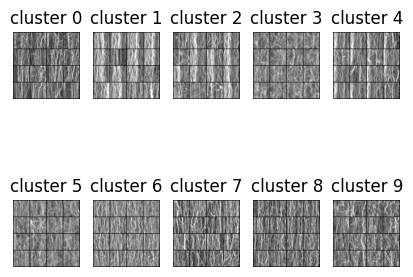

In [63]:
concatenated_images = image_concat_and_imshow(df_train_clustering, labels=np.arange(0,10), colrow=(4,4), image_root=image_pardir)
for i, img in enumerate(concatenated_images):
    img.save(figure_pardir / f"cluster_images_iter{max_iter}" / "4x4" / f"cluster{i}.png")

vbgmm_std_128_10clusters
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
  Iteration 350
  Iteration 360
  Iteration 370
  Iteration 380
  Iteration 390
  Iteration 400
  Iteration 410
  Iteration 420
  Iteration 430
  Iteration 440
  Iteration 450
  Iteration 460
  Iteration 470
  Iteration 480
  Iteration 490
  Iteration 500
  Iteration 510
  Iteration 520
  Iteration 530
  Iteration 540
  Iteration 550
  Iteration 560
  Iteration 570
  Iteration 580
  Iteration 590
Initialization converge

  Iteration 550
  Iteration 560
  Iteration 570
  Iteration 580
  Iteration 590
  Iteration 600
  Iteration 610
  Iteration 620
  Iteration 630
  Iteration 640
  Iteration 650
  Iteration 660
  Iteration 670
  Iteration 680
  Iteration 690
  Iteration 700
  Iteration 710
  Iteration 720
  Iteration 730
  Iteration 740
  Iteration 750
  Iteration 760
  Iteration 770
  Iteration 780
  Iteration 790
  Iteration 800
  Iteration 810
  Iteration 820
  Iteration 830
  Iteration 840
  Iteration 850
  Iteration 860
  Iteration 870
  Iteration 880
  Iteration 890
  Iteration 900
  Iteration 910
  Iteration 920
  Iteration 930
  Iteration 940
  Iteration 950
  Iteration 960
  Iteration 970
  Iteration 980
  Iteration 990
  Iteration 1000
Initialization converged: True
Initialization 7
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140


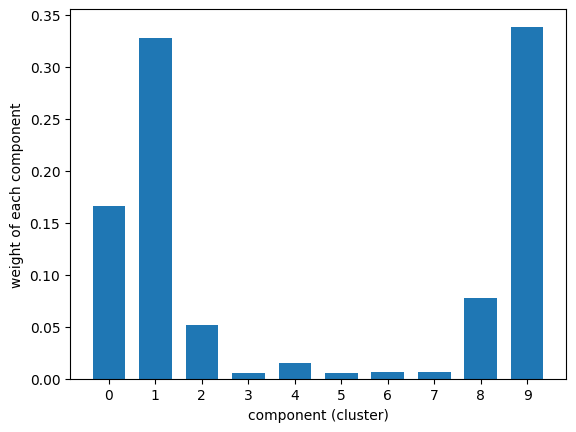

In [17]:
dt = datetime.datetime.now()

nc = 10

clustering_type = f'vbgmm_std_128_{nc}clusters'
print(clustering_type)

vbgmm_train_std_128_10 = BayesianGaussianMixture(
    n_components=nc,
    max_iter=1000,
    n_init=10,
    init_params="k-means++",
    verbose=1
)
y_train_std = vbgmm_train_std_128_10.fit_predict(X_train_std)

# model_save_dir = model_save_pardir / dt.strftime("%Y-%m-%d/%H-%M-%S")
model_save_dir = model_save_pardir / trained_datetime
if not model_save_dir.exists():
    os.makedirs(model_save_dir)
joblib.dump(vbgmm_train_std_128_10, model_save_dir / "vbgmm_train_std_128_10.pkl")

rank_of_cluster_train_std = rankdata(- vbgmm_train_std_128_10.weights_, method='ordinal')
y_train_std_sorted_cluster = rank_of_cluster_train_std[y_train_std]

# plt.subplot(4, 1, 4)
x_tick = np.arange(0, nc)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, vbgmm_train_std_128_10.weights_, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

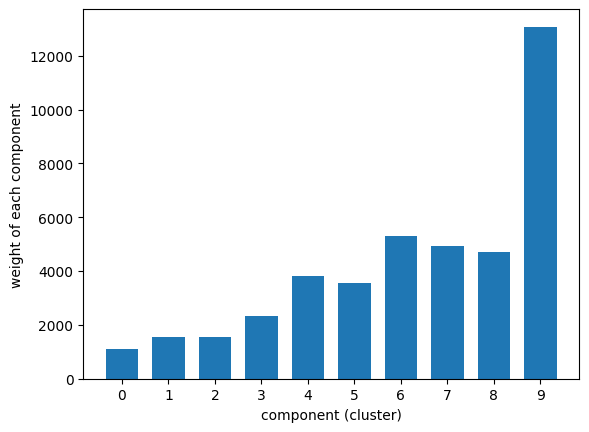

In [15]:
hist, bin_edges = np.histogram(y_train_std_sorted_cluster)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, hist, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

In [18]:
model_save_dir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/models/VBGMM/2023-07-10/13-09-32')

In [19]:
y_train_std = vbgmm_train_std_128_10.predict(X_train_std)
y_check_std = vbgmm_train_std_128_10.predict(X_check_std)

rank_of_cluster_train_std = rankdata(np.histogram(y_train_std)[0], method='ordinal')
y_train_std_sorted_cluster = rank_of_cluster_train_std[y_train_std]
y_check_std_sorted_cluster = rank_of_cluster_train_std[y_check_std]

max_abs_range=7.207655254352059


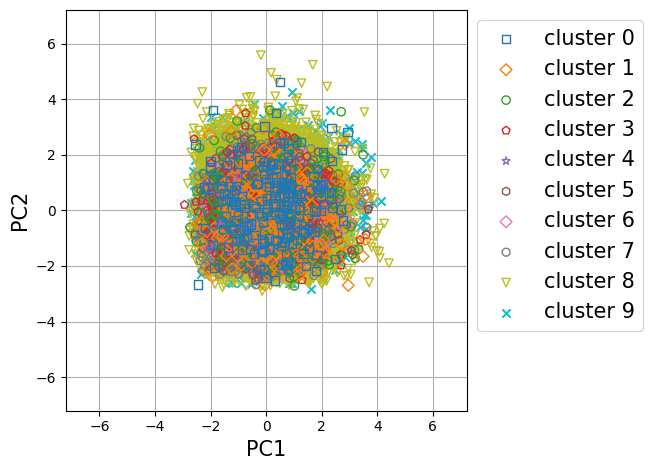

In [20]:
scatter_each_classes(
    X_train_std, 
    # cluster_labels, 
    y_train_std_sorted_cluster-1,
    np.arange(0, 10)[::-1],
    markers,
    colors,
    xylabel=("PC1", "PC2"),
    face_color="None",
    fontsize=15,
#     path="../reports/figures/VBGMM/2023-07-50/cluster_images/scatter.png"
)

In [19]:
feature_pardir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCVAE_softplus32/2023-07-18/19-08-34')

In [20]:
make_file_path_col = pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/").alias("filepath")
df_check_clustering = df_check.with_columns(
    [make_file_path_col, pl.Series("cluster", y_check_std_sorted_cluster-1)]
)
df_check_clustering.write_csv(feature_pardir / "feature_check_data_clustering.csv")
df_check_clustering.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,dirname,filename,filepath,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i64
0.371207,0.773912,0.321,0.97179,0.467441,-0.794627,0.155872,-0.429781,-0.62078,0.092581,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.466664,0.800218,0.09891,-0.229312,0.719136,-0.84856,1.146627,0.535144,0.163504,-0.539297,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",7
0.139828,-0.057409,-0.205014,-0.360194,0.178539,-0.288145,0.027653,-0.986673,-0.295563,-0.346313,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
0.108137,0.61107,-0.408147,0.128743,0.614519,-1.381092,-0.371074,0.507027,0.002102,0.196136,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",7
0.846178,-0.870254,-0.509567,0.478472,-0.679784,0.488236,-0.023896,0.480033,0.004727,-1.526124,0,"""10k_0_h000_w01…","""0/10k_0_h000_w…",9


In [21]:
make_file_path_col = pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/").alias("filepath")
df_train_clustering = df_train.with_columns(
    [make_file_path_col, pl.Series("cluster", y_train_std_sorted_cluster-1)]
)
df_train_clustering.write_csv(feature_pardir / "feature_train_data_clustering.csv")
df_train_clustering.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,dirname,filename,filepath,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i64
0.38649,0.75855,0.388386,1.012816,0.467618,-0.800058,0.161129,-0.432032,-0.632134,0.08859,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.193307,0.355739,0.189834,-0.427002,-0.923228,-1.006827,0.641109,-0.609367,0.176206,-0.414809,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.460056,0.780828,0.160261,-0.182374,0.721669,-0.856519,1.162508,0.54174,0.159463,-0.551491,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",7
0.16748,0.247725,-0.5245,-0.092569,0.035326,-0.131247,1.267444,-0.21511,-0.503101,-0.181691,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",7
0.149339,-0.07854,-0.121354,-0.315032,0.185015,-0.295195,0.033236,-0.989271,-0.296639,-0.360667,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9


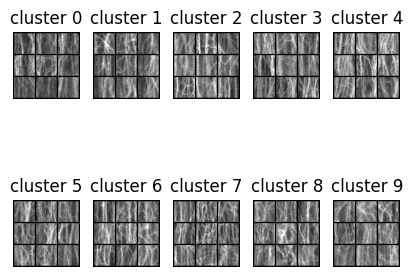

In [25]:
concatenated_images = image_concat_and_imshow(df_train_clustering, labels=np.arange(0,10), colrow=(3,3), image_root=image_pardir)
for i, img in enumerate(concatenated_images):
    img.save(f"/home/shinsei/MyResearchs/feat_extrc/reports/figures/VBGMM/2023-07-18/cluster_images/3x3/cluster{i}.png")